In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

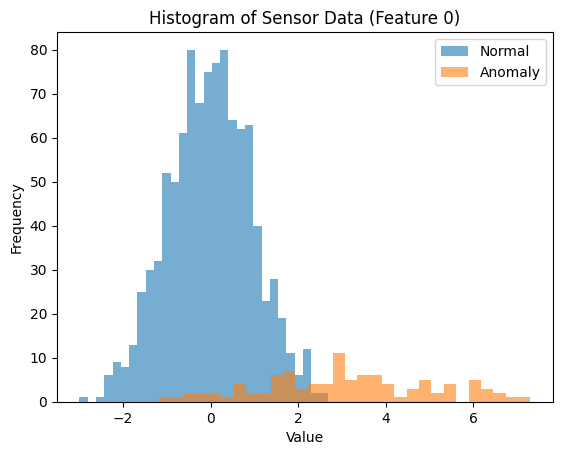

In [2]:
# Settings
np.random.seed(0) # For reproducibility
n_samples = 1000
n_features = 3
# Generation of "normal" data
data_normal = np.random.normal(loc=0, scale=1, size=(n_samples, n_features))
# Generation of "anomalous" data
data_anomaly = np.random.normal(loc=3, scale=2, size=(n_samples // 10, n_features))
# Data visualisation
plt.hist(data_normal[:,0], bins=30, alpha=0.6, label='Normal')
plt.hist(data_anomaly[:,0], bins=30, alpha=0.6, label='Anomaly')
plt.title("Histogram of Sensor Data (Feature 0)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [16]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            # nn.Linear(input_dim, encoding_dim),
            nn.Linear(encoding_dim ,input_dim),
            nn.ReLU(True))
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [33]:
# Data preparation
scaler = StandardScaler()
data_normal_scaled = scaler.fit_transform(data_normal)

# Conversion to PyTorch tensors
data_tensor = torch.tensor(data_normal_scaled, dtype=torch.float32)

# Example usage. Matrix multiplication, number of columns = number of rows
input_dim    = n_features  # Dimensionality of input data
# encoding_dim > input_dim -> overfitting? input_dim > encoding_dim
encoding_dim = n_features - 1  # Dimensionality of the encoding layer

# Initialize the autoencoder model
model = Autoencoder(input_dim, encoding_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training
n_epochs = 20
for epoch in range(n_epochs):
    optimizer.zero_grad()
    output = model(data_tensor)
    loss = criterion(output, data_tensor)
    loss.backward()
    optimizer.step()
    # if epoch % 5 == 0:
    #     print(f'Epoch {epoch+1}, Loss: {loss.item()}')


Number of anomalies detected in 'normal' data'   :  50/1000
Number of anomalies detected in 'anomalous' data':  89/100


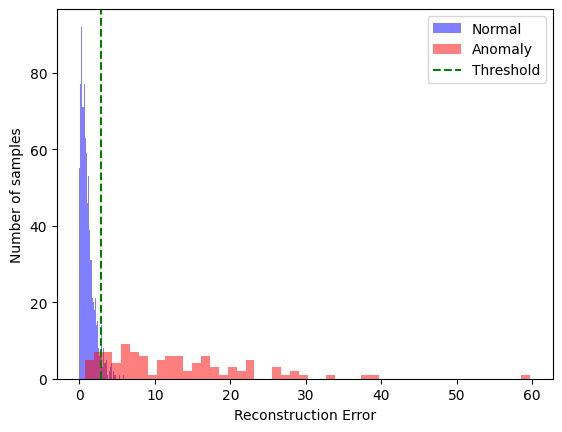

In [34]:
# Function for calculating the reconstruction error
def compute_reconstruction_error(model, data):
    with torch.no_grad():  # Disabling gradient calculations for acceleration
        predictions = model(data)
        loss = torch.mean((data - predictions) ** 2, dim=1)
    return loss

# Calculation of the reconstruction error for "normal" data
data_normal_tensor = torch.tensor(scaler.transform(data_normal), dtype=torch.float32)
normal_errors = compute_reconstruction_error(model, data_normal_tensor)
# Calculation of the reconstruction error for "anomalous" data
data_anomaly_tensor = torch.tensor(scaler.transform(data_anomaly), dtype=torch.float32)
anomaly_errors = compute_reconstruction_error(model, data_anomaly_tensor)
# Determination of anomaly detection threshold
threshold = np.quantile(normal_errors.numpy(), 0.95)  # e.g. 95 per cent error of normal data

# Anomaly detection
def detect_anomalies(errors, threshold):
    return errors > threshold

normal_detected = detect_anomalies(normal_errors, threshold)
anomaly_detected = detect_anomalies(anomaly_errors, threshold)

# Summary of results
print(f"Number of anomalies detected in 'normal' data'   :  {torch.sum(normal_detected).item()}/{len(data_normal)}")
print(f"Number of anomalies detected in 'anomalous' data':  {torch.sum(anomaly_detected).item()}/{len(data_anomaly)}")

# Visualisation of reconstruction errors
plt.hist(normal_errors.numpy(), bins=50, alpha=0.5, label='Normal', color='blue')
plt.hist(anomaly_errors.numpy(), bins=50, alpha=0.5, label='Anomaly', color='red')
plt.axvline(x=threshold, color='green', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Number of samples')
plt.legend()
plt.show()
